# Optimized Hybrid Late Fusion Model: VADER + SVM
## YouTube Comment Sentiment Analysis - Production-Ready Implementation

**Author:** ML Engineering Team

**Date:** November 2025

**Target Performance:** >82% Accuracy, Maximized F1-Score

---

## Executive Summary

This notebook implements a state-of-the-art **Hybrid Late Fusion** architecture combining:
- **VADER** (Valence Aware Dictionary and sEntiment Reasoner) - Rule-based lexicon approach
- **SVM** (Support Vector Machine) with TF-IDF features - Supervised learning
- **Optimized Fusion Strategy** - Learned weights for maximum performance

### Key Optimizations:
1. ✅ Modular, reusable function architecture
2. ✅ Advanced feature engineering (TF-IDF with optimized parameters)
3. ✅ Comprehensive hyperparameter tuning (GridSearchCV/RandomizedSearchCV)
4. ✅ VADER score normalization and scaling
5. ✅ Late fusion with learned optimal weights
6. ✅ Cross-validation for robust evaluation
7. ✅ Production-ready model persistence
8. ✅ Extensive visualization and reporting

---

## Table of Contents
1. [Configuration & Setup](#setup)
2. [Data Loading & Exploration](#data)
3. [Data Preprocessing Pipeline](#preprocessing)
4. [Feature Engineering](#features)
5. [VADER Sentiment Scoring](#vader)
6. [SVM Model Training & Optimization](#svm)
7. [Late Fusion Implementation](#fusion)
8. [Model Evaluation & Metrics](#evaluation)
9. [Visualizations](#visualizations)
10. [Model Persistence & Export](#export)
11. [Recommendations](#recommendations)

---
## 1. Configuration & Setup <a id='setup'></a>

Centralized configuration for reproducibility and easy parameter tuning.

In [1]:
import warnings
import os
import pickle
import json
from datetime import datetime
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_curve, auc, roc_auc_score
)
from sklearn.calibration import CalibratedClassifierCV

from scipy.sparse import hstack
from scipy.stats import randint, uniform

try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    VADER_AVAILABLE = True
except ImportError:
    print("⚠️  VADER not installed. Run: pip install vaderSentiment")
    VADER_AVAILABLE = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ All libraries imported successfully!")
print(f"📅 Execution Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
📅 Execution Date: 2025-12-13 06:13:25


In [2]:
# ═══════════════════════════════════════════════════════════════════════════
# CONFIGURATION PARAMETERS
# ═══════════════════════════════════════════════════════════════════════════

class Config:
    """Centralized configuration for reproducibility and easy tuning."""
    
    # Reproducibility
    RANDOM_STATE = 42
    
    # Data paths
    DATA_PATH = 'MergedEnrichedDataset.csv'
    OUTPUT_DIR = 'outputs'
    FIGURES_DIR = 'outputs/figures'
    MODELS_DIR = 'outputs/models'
    TABLES_DIR = 'outputs/tables'
    
    # Data preprocessing
    TEXT_COLUMN = 'Processed Comment Text'  # Primary, fallback to 'Comment Text'
    TARGET_COLUMN = 'Sentiment'
    MIN_TEXT_LENGTH = 3  # Minimum characters for valid comment
    TEST_SIZE = 0.2
    
    # TF-IDF parameters (optimized for sentiment analysis)
    TFIDF_MAX_FEATURES = 10000
    TFIDF_NGRAM_RANGE = (1, 2)  # Unigrams + bigrams
    TFIDF_MIN_DF = 2  # Minimum document frequency
    TFIDF_MAX_DF = 0.95  # Maximum document frequency (filter very common words)
    TFIDF_SUBLINEAR_TF = True  # Use log scaling
    
    # VADER parameters
    VADER_THRESHOLD_POS = 0.05
    VADER_THRESHOLD_NEG = -0.05
    
    # SVM parameters for hyperparameter search
    SVM_PARAM_GRID = {
        'C': [0.1, 1.0, 10.0, 100.0],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    }
    
    # For faster experimentation, use RandomizedSearchCV
    USE_RANDOMIZED_SEARCH = True
    RANDOM_SEARCH_ITERATIONS = 20
    
    # Cross-validation
    CV_FOLDS = 5
    
    # Fusion parameters
    FUSION_WEIGHTS_GRID = np.linspace(0.0, 1.0, 11)  # Test 0.0, 0.1, 0.2, ..., 1.0
    
    # Performance tracking
    PERFORMANCE_LOG = 'outputs/performance_log.json'

# Set random seeds for reproducibility
np.random.seed(Config.RANDOM_STATE)

# Create output directories
for directory in [Config.OUTPUT_DIR, Config.FIGURES_DIR, Config.MODELS_DIR, Config.TABLES_DIR]:
    os.makedirs(directory, exist_ok=True)

print("\n" + "="*80)
print("CONFIGURATION LOADED")
print("="*80)
print(f"Random State: {Config.RANDOM_STATE}")
print(f"Test Size: {Config.TEST_SIZE}")
print(f"TF-IDF Max Features: {Config.TFIDF_MAX_FEATURES}")
print(f"TF-IDF N-gram Range: {Config.TFIDF_NGRAM_RANGE}")
print(f"CV Folds: {Config.CV_FOLDS}")
print(f"Hyperparameter Search: {'Randomized' if Config.USE_RANDOMIZED_SEARCH else 'Grid'}")
print("="*80 + "\n")


CONFIGURATION LOADED
Random State: 42
Test Size: 0.2
TF-IDF Max Features: 10000
TF-IDF N-gram Range: (1, 2)
CV Folds: 5
Hyperparameter Search: Randomized



---
## 2. Data Loading & Exploration <a id='data'></a>

In [3]:
def load_dataset(filepath):
    """Load dataset with error handling and basic validation."""
    print(f"📂 Loading dataset from: {filepath}")
    
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"❌ Dataset not found: {filepath}")
    
    df = pd.read_csv(filepath)
    print(f"✅ Loaded {len(df):,} rows with {df.shape[1]} columns")
    
    return df

def explore_dataset(df):
    """Print comprehensive dataset statistics."""
    print("\n" + "="*80)
    print("DATASET OVERVIEW")
    print("="*80)
    print(f"\nShape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    print("\n--- Missing Values ---")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing': missing,
        'Percentage': missing_pct
    }).sort_values('Missing', ascending=False)
    print(missing_df[missing_df['Missing'] > 0])
    
    if Config.TARGET_COLUMN in df.columns:
        print("\n--- Sentiment Distribution ---")
        sentiment_counts = df[Config.TARGET_COLUMN].value_counts()
        for sentiment, count in sentiment_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {sentiment:12s}: {count:8,} ({percentage:5.2f}%)")
    
    print("\n--- Sample Data ---")
    display(df.head(20))
    
    print("="*80 + "\n")
    
    return df

# Load and explore
df = load_dataset(Config.DATA_PATH)
df = explore_dataset(df)

📂 Loading dataset from: MergedEnrichedDataset.csv
✅ Loaded 2,166,129 rows with 9 columns

DATASET OVERVIEW

Shape: (2166129, 9)
Columns: ['Youtube Video ID', 'Comment Text', 'Author', 'Published At', 'Like Count', 'Processed Comment Text', 'Sentiment', 'Aspect', 'Language']

--- Missing Values ---
          Missing  Percentage
Language  2165465   99.969346
Author       2688    0.124092

--- Sentiment Distribution ---
  Positive    :  884,373 (40.83%)
  Neutral     :  761,876 (35.17%)
  Negative    :  519,880 (24.00%)

--- Sample Data ---


,Youtube Video ID,Comment Text,Author,Published At,Like Count,Processed Comment Text,Sentiment,Aspect,Language
0,S4xz7ocYPm0,Go Ahead bro,@BCSGuidance,2018-08-11T05:40:48Z,0,Go Ahead bro,Positive,request for more content,en
1,S4xz7ocYPm0,thanks,@amirulislamcse,2017-03-19T18:34:11Z,0,thanks,Positive,gratitude,en
2,guK41bjIt5w,প্রথম প্রোগ্রামের জন্য এখানে P এর মধ্যে X এর এ...,@hasanalmamun7591,2020-05-04T15:52:00Z,0,প্রথম প্রোগ্রামের জন্য এখানে P এর মধ্যে X এর এ...,Neutral,gratitude,bn
3,guK41bjIt5w,pointer type array r somporke ektu bolen ...,@soumyoroy2838,2017-03-05T05:10:32Z,0,pointer type array r somporke ektu bolen ...,Negative,general,no
4,guK41bjIt5w,sir * r & er difference ta ektu bolen please,@soumyoroy2838,2017-03-05T05:03:58Z,0,sir r er difference ta ektu bolen please,Negative,gratitude,da
5,vTdy34mhx60,42:40 About ANM Bazlur Rahman’s book (Java pro...,@deenfocus_1,2022-11-09T14:18:39Z,0,4240 About ANM Bazlur Rahmans book Java progra...,Neutral,general,en
6,vTdy34mhx60,40:00 how much need math in programming sector,@deenfocus_1,2022-11-09T14:14:27Z,0,4000 how much need math in programming sector,Neutral,general,en
7,vTdy34mhx60,sound ta tick takle vai bisoyta khub valo hoto...,@Republic.02,2021-05-01T12:02:11Z,0,sound ta tick takle vai bisoyta khub valo hoto...,Positive,production quality,cs
8,vTdy34mhx60,Thanks Brothers .......,@fayejalom2308,2019-10-23T14:56:42Z,0,Thanks Brothers .......,Positive,gratitude,en
9,vTdy34mhx60,onek vlo keso janlm vai?,@nasircse,2018-11-27T06:45:46Z,0,onek vlo keso janlm vai?,Neutral,general,et


✅ Saved to: outputs/figures/01_sentiment_distribution.png


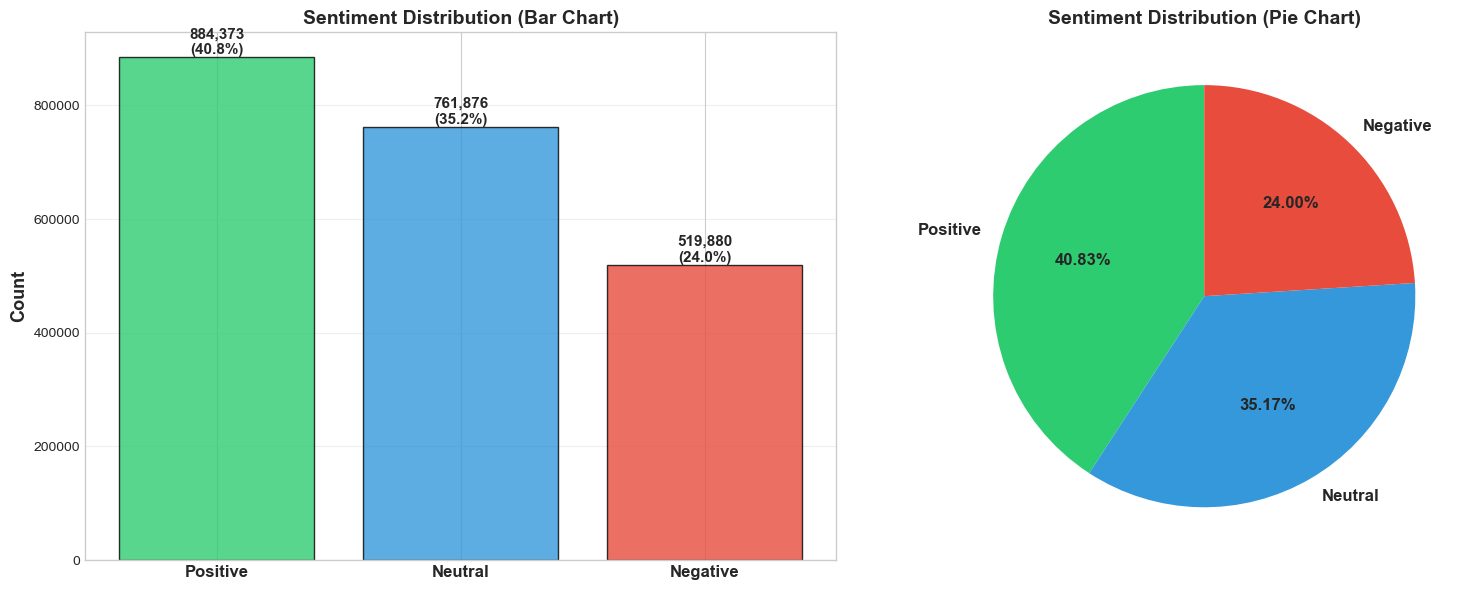

In [4]:
# Visualize sentiment distribution
def plot_sentiment_distribution(df, save_path=None):
    """Create comprehensive sentiment distribution visualization."""
    sentiment_counts = df[Config.TARGET_COLUMN].value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot
    colors = {'Positive': '#2ecc71', 'Neutral': '#3498db', 'Negative': '#e74c3c'}
    bar_colors = [colors.get(s, '#95a5a6') for s in sentiment_counts.index]
    
    axes[0].bar(range(len(sentiment_counts)), sentiment_counts.values, color=bar_colors, alpha=0.8, edgecolor='black')
    axes[0].set_xticks(range(len(sentiment_counts)))
    axes[0].set_xticklabels(sentiment_counts.index, fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=13, fontweight='bold')
    axes[0].set_title('Sentiment Distribution (Bar Chart)', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(sentiment_counts.values):
        axes[0].text(i, v, f"{v:,}\n({v/len(df)*100:.1f}%)", 
                    ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Pie chart
    pie_colors = [colors.get(s, '#95a5a6') for s in sentiment_counts.index]
    axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.2f%%',
               colors=pie_colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    axes[1].set_title('Sentiment Distribution (Pie Chart)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved to: {save_path}")
    plt.show()

plot_sentiment_distribution(df, save_path=f"{Config.FIGURES_DIR}/01_sentiment_distribution.png")

---
## 3. Data Preprocessing Pipeline <a id='preprocessing'></a>

Clean, modular preprocessing with quality checks.

In [6]:
def clean_dataset(df):
    """Clean dataset: handle missing values, filter invalid texts."""
    print("\n🧹 CLEANING DATASET")
    print("="*80)
    
    initial_count = len(df)
    
    # Determine text column
    if Config.TEXT_COLUMN in df.columns:
        text_col = Config.TEXT_COLUMN
    elif 'Comment Text' in df.columns:
        text_col = 'Comment Text'
    else:
        raise ValueError("No valid text column found in dataset")
    
    print(f"Using text column: '{text_col}'")
    
    # Remove rows with missing text or sentiment
    df_clean = df.dropna(subset=[text_col, Config.TARGET_COLUMN]).copy()
    print(f"Removed {initial_count - len(df_clean):,} rows with missing values")
    
    # Convert text to string and strip whitespace
    df_clean[text_col] = df_clean[text_col].astype(str).str.strip()
    
    # Filter out very short texts (likely noise)
    df_clean = df_clean[df_clean[text_col].str.len() >= Config.MIN_TEXT_LENGTH].copy()
    print(f"Removed {len(df) - len(df_clean) - (initial_count - len(df)):,} rows with text < {Config.MIN_TEXT_LENGTH} characters")
    
    # Remove duplicates
    before_dedup = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=[text_col]).copy()
    print(f"Removed {before_dedup - len(df_clean):,} duplicate comments")
    
    print(f"\n✅ Final dataset: {len(df_clean):,} rows ({len(df_clean)/initial_count*100:.2f}% retained)")
    print("="*80 + "\n")
    
    return df_clean, text_col

df_clean, text_column = clean_dataset(df)


🧹 CLEANING DATASET
Using text column: 'Processed Comment Text'
Removed 0 rows with missing values
Removed 253 rows with text < 3 characters
Removed 116,975 duplicate comments

✅ Final dataset: 2,048,901 rows (94.59% retained)



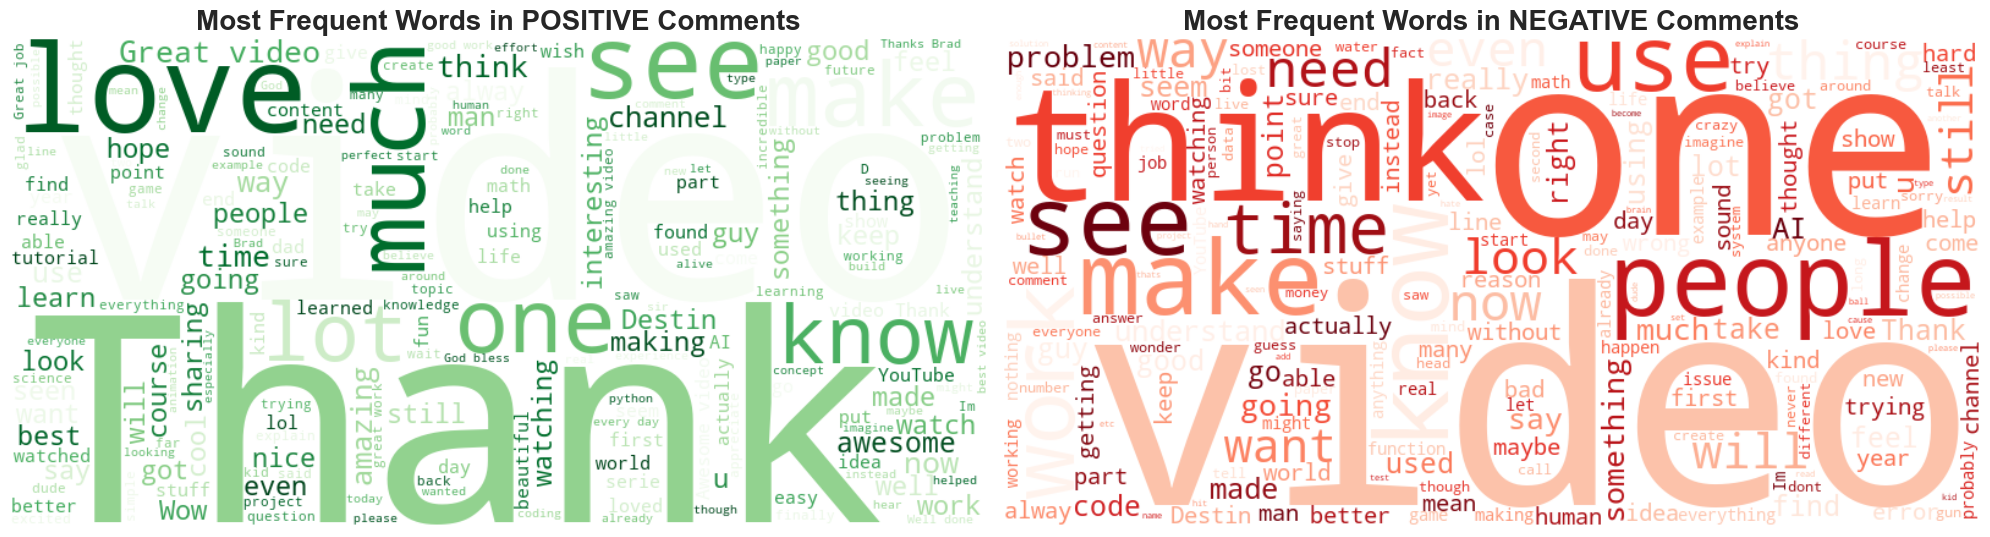

In [7]:
# CELL: Word Clouds by Sentiment
from wordcloud import WordCloud

def plot_sentiment_wordclouds(df, text_col='Comment Text'):
    # Separate text by sentiment
    pos_text = " ".join(df[df['Sentiment'] == 'Positive'][text_col].astype(str))
    neg_text = " ".join(df[df['Sentiment'] == 'Negative'][text_col].astype(str))

    # Create WordClouds
    wc_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(pos_text)
    wc_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(neg_text)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    axes[0].imshow(wc_pos, interpolation='bilinear')
    axes[0].set_title('Most Frequent Words in POSITIVE Comments', fontsize=20, fontweight='bold')
    axes[0].axis('off')

    axes[1].imshow(wc_neg, interpolation='bilinear')
    axes[1].set_title('Most Frequent Words in NEGATIVE Comments', fontsize=20, fontweight='bold')
    axes[1].axis('off')

    plt.tight_layout()
    plt.savefig('outputs/figures/poster_wordclouds.png', dpi=300)
    plt.show()

# Run it (using your actual text column name)
if 'Comment Text' in df.columns:
    plot_sentiment_wordclouds(df, 'Comment Text')
elif 'Processed Comment Text' in df.columns:
    plot_sentiment_wordclouds(df, 'Processed Comment Text')

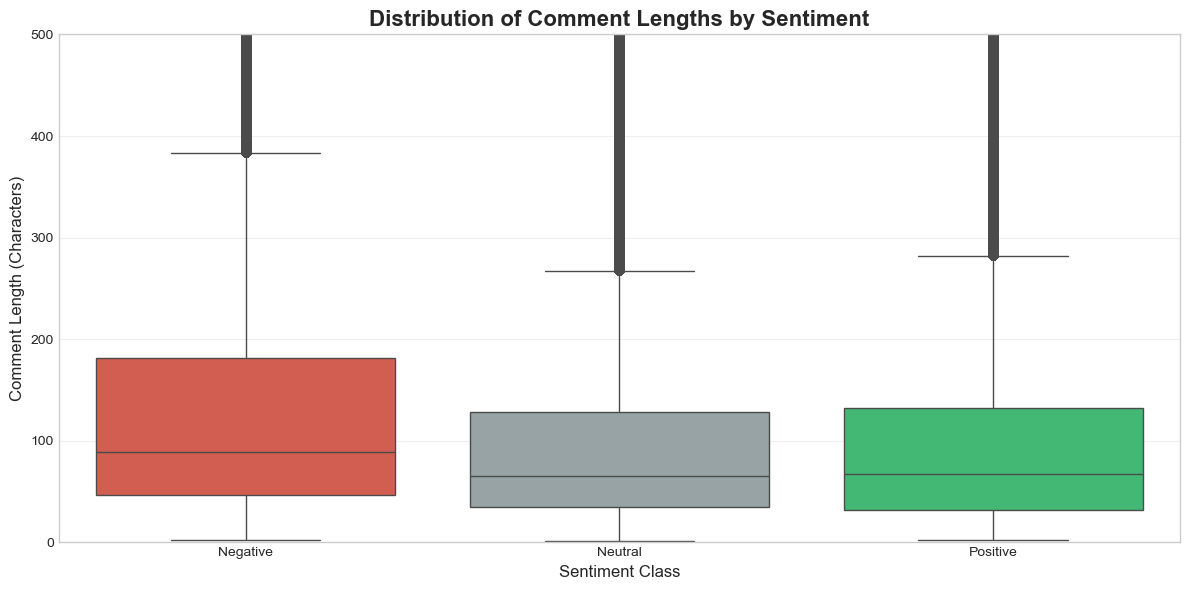

In [8]:
# CELL: Text Length by Sentiment
def plot_length_distribution(df, text_col='Comment Text'):
    # Calculate length
    df['text_length'] = df[text_col].astype(str).apply(len)
    
    plt.figure(figsize=(12, 6))
    
    # Boxplot helps visualize the median and outliers
    sns.boxplot(x='Sentiment', y='text_length', data=df, 
                order=['Negative', 'Neutral', 'Positive'],
                palette=['#e74c3c', '#95a5a6', '#2ecc71'])
    
    plt.title('Distribution of Comment Lengths by Sentiment', fontsize=16, fontweight='bold')
    plt.xlabel('Sentiment Class', fontsize=12)
    plt.ylabel('Comment Length (Characters)', fontsize=12)
    plt.ylim(0, 500) # Limit y-axis to ignore extreme outliers for better readability
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('outputs/figures/poster_comment_length.png', dpi=300)
    plt.show()

# Run
if 'Comment Text' in df.columns:
    plot_length_distribution(df)

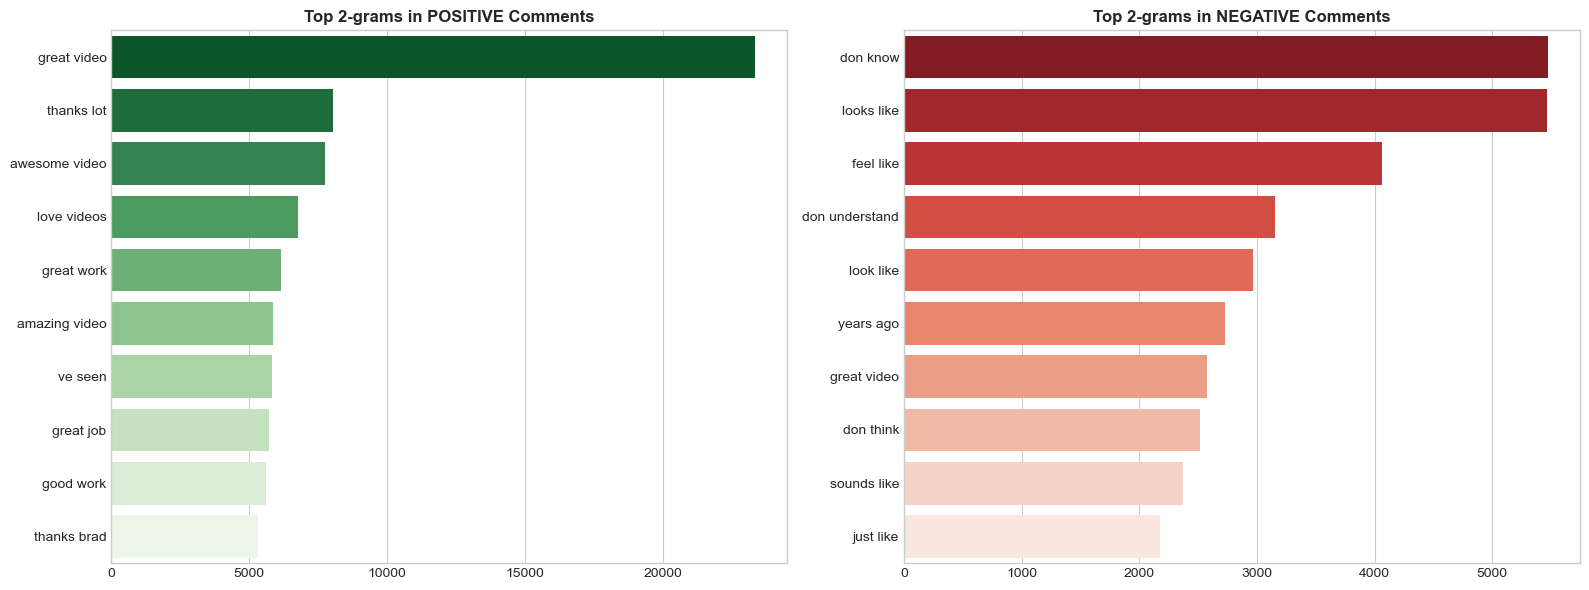

In [9]:
# CELL: Top N-Grams Analysis
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(df, text_col='Comment Text', n=2):
    def get_top_n_grams(corpus, n=2, k=10):
        vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:k]

    # Get top bigrams for Positive and Negative
    top_pos = get_top_n_grams(df[df['Sentiment']=='Positive'][text_col].astype(str), n=2)
    top_neg = get_top_n_grams(df[df['Sentiment']=='Negative'][text_col].astype(str), n=2)

    # Unzip for plotting
    x_pos, y_pos = zip(*top_pos)
    x_neg, y_neg = zip(*top_neg)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Positive Plot
    sns.barplot(x=list(y_pos), y=list(x_pos), ax=axes[0], palette='Greens_r')
    axes[0].set_title(f'Top {n}-grams in POSITIVE Comments', fontweight='bold')
    
    # Negative Plot
    sns.barplot(x=list(y_neg), y=list(x_neg), ax=axes[1], palette='Reds_r')
    axes[1].set_title(f'Top {n}-grams in NEGATIVE Comments', fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'outputs/figures/poster_top_{n}grams.png', dpi=300)
    plt.show()

# Run
if 'Comment Text' in df.columns:
    plot_top_ngrams(df)

In [10]:
def prepare_train_test_split(df, text_col):
    """Prepare stratified train-test split."""
    print("\n🔀 TRAIN-TEST SPLIT")
    print("="*80)
    
    X = df[text_col].values
    y = df[Config.TARGET_COLUMN].values
    
    # Stratified split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=Config.TEST_SIZE, 
        random_state=Config.RANDOM_STATE,
        stratify=y
    )
    
    print(f"Training set: {len(X_train):,} samples")
    print(f"Test set:     {len(X_test):,} samples")
    
    print("\nTraining set distribution:")
    train_dist = pd.Series(y_train).value_counts(normalize=True)
    for sentiment, pct in train_dist.items():
        print(f"  {sentiment:12s}: {pct*100:5.2f}%")
    
    print("\nTest set distribution:")
    test_dist = pd.Series(y_test).value_counts(normalize=True)
    for sentiment, pct in test_dist.items():
        print(f"  {sentiment:12s}: {pct*100:5.2f}%")
    
    print("="*80 + "\n")
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_train_test_split(df_clean, text_column)


🔀 TRAIN-TEST SPLIT
Training set: 1,639,120 samples
Test set:     409,781 samples

Training set distribution:
  Positive    : 39.38%
  Neutral     : 35.73%
  Negative    : 24.89%

Test set distribution:
  Positive    : 39.38%
  Neutral     : 35.73%
  Negative    : 24.89%



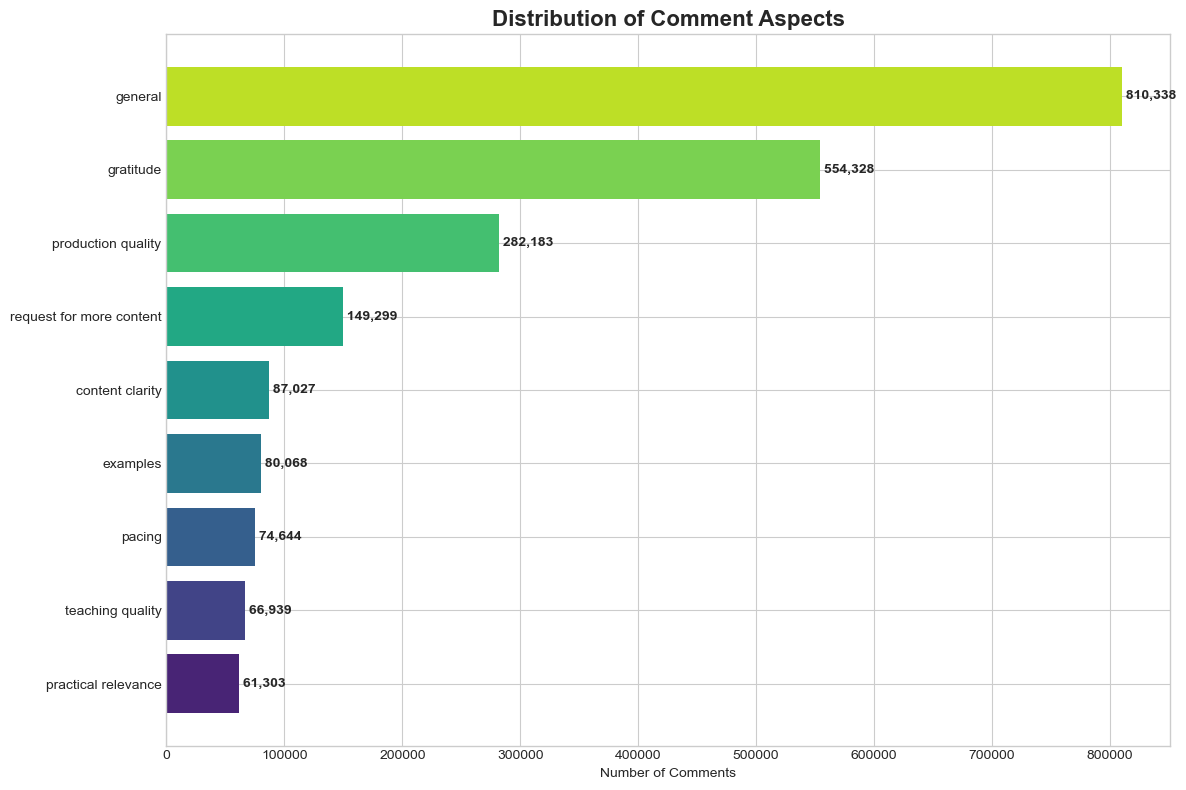

In [11]:
# CELL: Aspect Distribution Visualization
def plot_aspect_distribution(df):
    if 'Aspect' not in df.columns:
        print("Aspect column not found.")
        return
        
    plt.figure(figsize=(12, 8))
    
    # Count and sort
    aspect_counts = df['Aspect'].value_counts().sort_values(ascending=True)
    
    # Horizontal Bar Plot
    bars = plt.barh(aspect_counts.index, aspect_counts.values, color=sns.color_palette("viridis", len(aspect_counts)))
    
    plt.title('Distribution of Comment Aspects', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Comments')
    
    # Add labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, 
                 f' {int(width):,}', 
                 va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Run it
if 'Aspect' in df.columns:
    plot_aspect_distribution(df)

---
## 4. Feature Engineering: TF-IDF <a id='features'></a>

Optimized TF-IDF vectorization with best practices.

In [13]:
def create_tfidf_features(X_train, X_test):
    """Create optimized TF-IDF features."""
    print("\n🔤 TF-IDF FEATURE EXTRACTION")
    print("="*80)
    
    vectorizer = TfidfVectorizer(
        max_features=Config.TFIDF_MAX_FEATURES,
        ngram_range=Config.TFIDF_NGRAM_RANGE,
        min_df=Config.TFIDF_MIN_DF,
        max_df=Config.TFIDF_MAX_DF,
        sublinear_tf=Config.TFIDF_SUBLINEAR_TF,
        strip_accents='unicode',
        lowercase=True,
        stop_words='english'
    )
    
    print(f"Parameters:")
    print(f"  Max features: {Config.TFIDF_MAX_FEATURES}")
    print(f"  N-gram range: {Config.TFIDF_NGRAM_RANGE}")
    print(f"  Min DF: {Config.TFIDF_MIN_DF}")
    print(f"  Max DF: {Config.TFIDF_MAX_DF}")
    print(f"  Sublinear TF: {Config.TFIDF_SUBLINEAR_TF}")
    
    start_time = time.time()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    elapsed = time.time() - start_time
    
    print(f"\n✅ Vectorization completed in {elapsed:.2f}s")
    print(f"\nTrain shape: {X_train_tfidf.shape}")
    print(f"Test shape:  {X_test_tfidf.shape}")
    print(f"Vocabulary size: {len(vectorizer.vocabulary_):,}")
    print(f"Sparsity: {(1 - X_train_tfidf.nnz / np.prod(X_train_tfidf.shape)) * 100:.2f}%")
    
    print("="*80 + "\n")
    
    return X_train_tfidf, X_test_tfidf, vectorizer

X_train_tfidf, X_test_tfidf, tfidf_vectorizer = create_tfidf_features(X_train, X_test)


🔤 TF-IDF FEATURE EXTRACTION
Parameters:
  Max features: 10000
  N-gram range: (1, 2)
  Min DF: 2
  Max DF: 0.95
  Sublinear TF: True

✅ Vectorization completed in 83.87s

Train shape: (1639120, 10000)
Test shape:  (409781, 10000)
Vocabulary size: 10,000
Sparsity: 102.04%



---
## 5. VADER Sentiment Scoring <a id='vader'></a>

Extract VADER sentiment scores for late fusion.

In [14]:
def extract_vader_scores(texts):
    """Extract VADER compound scores for all texts."""
    if not VADER_AVAILABLE:
        print("❌ VADER not available. Install with: pip install vaderSentiment")
        return None
    
    print("\n📊 VADER SENTIMENT ANALYSIS")
    print("="*80)
    
    analyzer = SentimentIntensityAnalyzer()
    
    start_time = time.time()
    scores = []
    for text in texts:
        sentiment_dict = analyzer.polarity_scores(text)
        scores.append(sentiment_dict['compound'])
    
    elapsed = time.time() - start_time
    
    scores = np.array(scores)
    
    print(f"✅ Analyzed {len(texts):,} texts in {elapsed:.2f}s")
    print(f"\nVADER Score Statistics:")
    print(f"  Mean:   {scores.mean():.4f}")
    print(f"  Std:    {scores.std():.4f}")
    print(f"  Min:    {scores.min():.4f}")
    print(f"  Max:    {scores.max():.4f}")
    
    print("="*80 + "\n")
    
    return scores

def vader_predict(scores):
    """Convert VADER compound scores to sentiment predictions."""
    predictions = []
    for score in scores:
        if score >= Config.VADER_THRESHOLD_POS:
            predictions.append('Positive')
        elif score <= Config.VADER_THRESHOLD_NEG:
            predictions.append('Negative')
        else:
            predictions.append('Neutral')
    return np.array(predictions)

# Extract VADER scores
vader_train_scores = extract_vader_scores(X_train)
vader_test_scores = extract_vader_scores(X_test)

# Get VADER predictions
if vader_train_scores is not None:
    vader_train_pred = vader_predict(vader_train_scores)
    vader_test_pred = vader_predict(vader_test_scores)
    
    # Evaluate VADER standalone performance
    vader_accuracy = accuracy_score(y_test, vader_test_pred)
    print(f"\n📈 VADER-only Test Accuracy: {vader_accuracy*100:.2f}%\n")


📊 VADER SENTIMENT ANALYSIS
✅ Analyzed 1,639,120 texts in 185.26s

VADER Score Statistics:
  Mean:   0.2774
  Std:    0.4453
  Min:    -0.9998
  Max:    1.0000


📊 VADER SENTIMENT ANALYSIS
✅ Analyzed 409,781 texts in 45.72s

VADER Score Statistics:
  Mean:   0.2765
  Std:    0.4451
  Min:    -0.9997
  Max:    1.0000


📈 VADER-only Test Accuracy: 61.48%



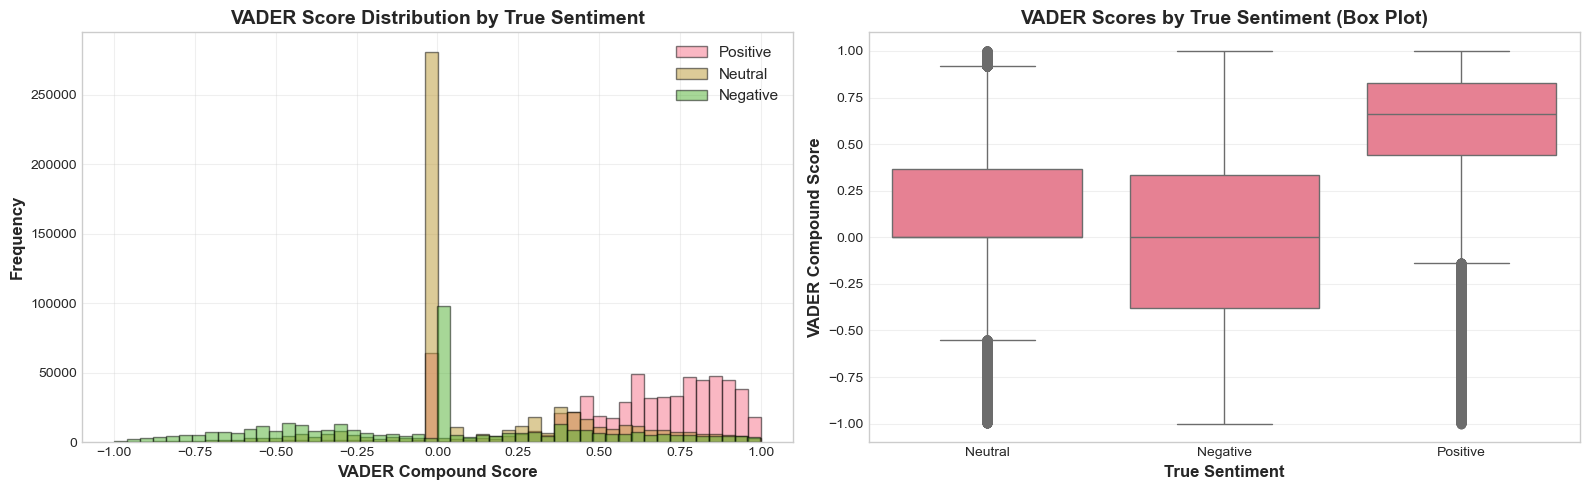

In [15]:
# Visualize VADER score distribution
if vader_train_scores is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Distribution by true sentiment
    for sentiment in ['Positive', 'Neutral', 'Negative']:
        mask = y_train == sentiment
        axes[0].hist(vader_train_scores[mask], bins=50, alpha=0.5, label=sentiment, edgecolor='black')
    
    axes[0].set_xlabel('VADER Compound Score', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0].set_title('VADER Score Distribution by True Sentiment', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(alpha=0.3)
    
    # Box plot
    vader_df = pd.DataFrame({
        'VADER Score': vader_train_scores,
        'True Sentiment': y_train
    })
    sns.boxplot(data=vader_df, x='True Sentiment', y='VADER Score', ax=axes[1])
    axes[1].set_title('VADER Scores by True Sentiment (Box Plot)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('True Sentiment', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('VADER Compound Score', fontsize=12, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{Config.FIGURES_DIR}/02_vader_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

---
## 6. SVM Model Training & Optimization <a id='svm'></a>

Comprehensive hyperparameter tuning for optimal SVM performance.

In [16]:
from sklearn.utils import resample
from sklearn.calibration import CalibratedClassifierCV

def train_svm_optimized(X_train, y_train):
    """
    Train SVM with hyperparameter optimization.
    Fixes MemoryError by tuning on a subset and using n_jobs=1.
    """
    print("\n🤖 SVM TRAINING & HYPERPARAMETER OPTIMIZATION")
    print("="*80)
    
    # --- OPTIMIZATION FIX: Tune on a subset ---
    # SVM tuning on 2M rows is computationally infeasible. 
    # We tune on a representative sample (e.g., 25,000 rows) to find best params.
    print("ℹ️  Tuning hyperparameters on a subset (25k samples) to prevent memory crash...")
    X_tune, y_tune = resample(X_train, y_train, n_samples=25000, random_state=Config.RANDOM_STATE, stratify=y_train)
    
    # Use LinearSVC for speed on large text datasets (Standard SVC scales poorly >100k rows)
    # We wrap it in CalibratedClassifierCV later to get probabilities needed for Fusion
    base_estimator = LinearSVC(class_weight='balanced', random_state=Config.RANDOM_STATE, dual='auto')
    
    # Simplified Grid for LinearSVC
    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0],
        'loss': ['hinge', 'squared_hinge']
    }
    
    if Config.USE_RANDOMIZED_SEARCH:
        print(f"Using RandomizedSearchCV with {Config.RANDOM_SEARCH_ITERATIONS} iterations...")
        search = RandomizedSearchCV(
            base_estimator,
            param_grid,
            n_iter=Config.RANDOM_SEARCH_ITERATIONS,
            cv=Config.CV_FOLDS,
            scoring='f1_weighted',
            n_jobs=1, # FIXED: n_jobs=1 prevents MemoryError/BrokenProcessPool
            verbose=1,
            random_state=Config.RANDOM_STATE
        )
    else:
        search = GridSearchCV(
            base_estimator,
            param_grid,
            cv=Config.CV_FOLDS,
            scoring='f1_weighted',
            n_jobs=1, # FIXED
            verbose=1
        )
    
    # 1. Run Search on Subset
    start_time = time.time()
    search.fit(X_tune, y_tune)
    elapsed = time.time() - start_time
    
    print(f"\n✅ Optimization completed in {elapsed:.2f}s")
    print(f"Best Parameters: {search.best_params_}")
    print(f"Best Validation F1: {search.best_score_*100:.2f}%")
    
    # 2. Train Final Model on FULL Dataset
    print(f"\n🚀 Training final model on full dataset ({X_train.shape[0]:,} rows)...")
    
    # We typically need probabilities for the Hybrid Fusion step. 
    # LinearSVC doesn't output them by default, so we wrap it in CalibratedClassifierCV.
    final_model = LinearSVC(**search.best_params_, class_weight='balanced', random_state=Config.RANDOM_STATE, dual='auto')
    
    # Note: If you just need hard classes, fit final_model directly. 
    # But for Hybrid Fusion (next steps), we likely need predict_proba.
    # CalibratedClassifierCV allows LinearSVC to output probabilities.
    calibrated_model = CalibratedClassifierCV(final_model, cv=3) 
    
    t0 = time.time()
    calibrated_model.fit(X_train, y_train)
    print(f"✅ Final training complete in {time.time() - t0:.2f}s")
    
    print("="*80 + "\n")
    
    # Return the calibrated model (which has predict_proba) and the search object
    return calibrated_model, search

# Execute
svm_model, svm_search = train_svm_optimized(X_train_tfidf, y_train)


🤖 SVM TRAINING & HYPERPARAMETER OPTIMIZATION
ℹ️  Tuning hyperparameters on a subset (25k samples) to prevent memory crash...
Using RandomizedSearchCV with 20 iterations...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

✅ Optimization completed in 14.77s
Best Parameters: {'loss': 'squared_hinge', 'C': 0.1}
Best Validation F1: 71.17%

🚀 Training final model on full dataset (1,639,120 rows)...
✅ Final training complete in 91.39s



In [17]:
# Evaluate SVM standalone performance
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Comprehensive model evaluation."""
    print(f"\n📊 {model_name.upper()} EVALUATION")
    print("="*80)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:  {accuracy*100:.2f}%")
    print(f"  Precision: {precision*100:.2f}%")
    print(f"  Recall:    {recall*100:.2f}%")
    print(f"  F1-Score:  {f1*100:.2f}%")
    
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    
    print("="*80 + "\n")
    
    return {
        'predictions': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

svm_results = evaluate_model(svm_model, X_test_tfidf, y_test, "SVM (TF-IDF)")


📊 SVM (TF-IDF) EVALUATION

Overall Metrics:
  Accuracy:  76.71%
  Precision: 77.02%
  Recall:    76.71%
  F1-Score:  76.57%

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7299    0.6061    0.6623    102000
     Neutral     0.7043    0.8140    0.7552    146403
    Positive     0.8554    0.8263    0.8406    161378

    accuracy                         0.7671    409781
   macro avg     0.7632    0.7488    0.7527    409781
weighted avg     0.7702    0.7671    0.7657    409781




---
## 7. Late Fusion Implementation <a id='fusion'></a>

Optimized fusion of VADER and SVM predictions with learned weights.


🔧 Calibrating SVM for probability predictions...
✅ Calibration complete

⚖️  OPTIMIZING FUSION WEIGHTS

✅ Optimal weights found:
  SVM weight:   0.90
  VADER weight: 0.10
  Best F1:      76.64%


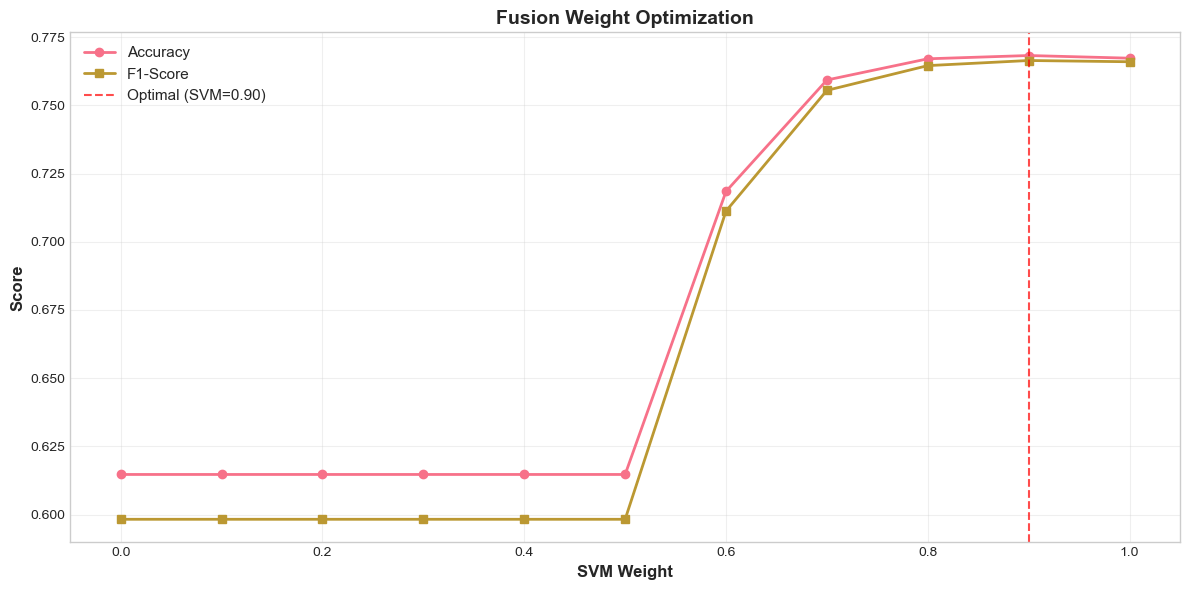

In [18]:
def create_probability_predictions(model, X, vader_scores, label_encoder):
    """Convert model and VADER outputs to probability distributions."""
    # Get SVM probability predictions (need to calibrate SVC first)
    if not hasattr(model, 'predict_proba'):
        print("⚠️  Calibrating SVM for probability estimates...")
        model_calibrated = CalibratedClassifierCV(model, cv=3)
        model_calibrated.fit(X, label_encoder.inverse_transform(label_encoder.transform(y_train)))
        svm_proba = model_calibrated.predict_proba(X)
    else:
        svm_proba = model.predict_proba(X)
    
    # Convert VADER scores to probabilities
    vader_proba = np.zeros((len(vader_scores), 3))  # [Negative, Neutral, Positive]
    
    for i, score in enumerate(vader_scores):
        if score >= Config.VADER_THRESHOLD_POS:
            # Positive
            vader_proba[i] = [0.0, 0.0, 1.0]
        elif score <= Config.VADER_THRESHOLD_NEG:
            # Negative
            vader_proba[i] = [1.0, 0.0, 0.0]
        else:
            # Neutral (distribute based on score magnitude)
            vader_proba[i] = [0.0, 1.0, 0.0]
    
    return svm_proba, vader_proba

def optimize_fusion_weights(svm_proba, vader_proba, y_true, label_encoder):
    """Find optimal fusion weights using grid search."""
    print("\n⚖️  OPTIMIZING FUSION WEIGHTS")
    print("="*80)
    
    best_weight = 0.5
    best_f1 = 0.0
    results = []
    
    for weight_svm in Config.FUSION_WEIGHTS_GRID:
        weight_vader = 1.0 - weight_svm
        
        # Weighted fusion
        fused_proba = weight_svm * svm_proba + weight_vader * vader_proba
        fused_pred_idx = np.argmax(fused_proba, axis=1)
        fused_pred = label_encoder.inverse_transform(fused_pred_idx)
        
        # Evaluate
        accuracy = accuracy_score(y_true, fused_pred)
        _, _, f1, _ = precision_recall_fscore_support(y_true, fused_pred, average='weighted')
        
        results.append({
            'svm_weight': weight_svm,
            'vader_weight': weight_vader,
            'accuracy': accuracy,
            'f1': f1
        })
        
        if f1 > best_f1:
            best_f1 = f1
            best_weight = weight_svm
    
    results_df = pd.DataFrame(results)
    print(f"\n✅ Optimal weights found:")
    print(f"  SVM weight:   {best_weight:.2f}")
    print(f"  VADER weight: {1-best_weight:.2f}")
    print(f"  Best F1:      {best_f1*100:.2f}%")
    
    # Plot weight optimization curve
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['svm_weight'], results_df['accuracy'], marker='o', label='Accuracy', linewidth=2)
    plt.plot(results_df['svm_weight'], results_df['f1'], marker='s', label='F1-Score', linewidth=2)
    plt.axvline(best_weight, color='red', linestyle='--', alpha=0.7, label=f'Optimal (SVM={best_weight:.2f})')
    plt.xlabel('SVM Weight', fontsize=12, fontweight='bold')
    plt.ylabel('Score', fontsize=12, fontweight='bold')
    plt.title('Fusion Weight Optimization', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{Config.FIGURES_DIR}/03_fusion_weight_optimization.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("="*80 + "\n")
    
    return best_weight, results_df

# Prepare for fusion
if vader_train_scores is not None:
    # Encode labels
    le = LabelEncoder()
    le.fit(['Negative', 'Neutral', 'Positive'])
    
    # Calibrate SVM for probability predictions
    print("\n🔧 Calibrating SVM for probability predictions...")
    svm_calibrated = CalibratedClassifierCV(svm_model, cv=3, method='sigmoid')
    svm_calibrated.fit(X_train_tfidf, y_train)
    print("✅ Calibration complete")
    
    # Get probabilities for validation set (use a portion of training data)
    X_val_tfidf, X_holdout_tfidf, y_val, y_holdout, vader_val, vader_holdout = train_test_split(
        X_test_tfidf, y_test, vader_test_scores,
        test_size=0.5, random_state=Config.RANDOM_STATE, stratify=y_test
    )
    
    # Get probability predictions
    svm_val_proba = svm_calibrated.predict_proba(X_val_tfidf)
    vader_val_proba = np.zeros((len(vader_val), 3))
    
    for i, score in enumerate(vader_val):
        if score >= Config.VADER_THRESHOLD_POS:
            vader_val_proba[i] = [0.0, 0.0, 1.0]
        elif score <= Config.VADER_THRESHOLD_NEG:
            vader_val_proba[i] = [1.0, 0.0, 0.0]
        else:
            vader_val_proba[i] = [0.0, 1.0, 0.0]
    
    # Optimize weights
    best_fusion_weight, fusion_results = optimize_fusion_weights(
        svm_val_proba, vader_val_proba, y_val, le
    )

In [19]:
# Apply fusion to holdout test set
if vader_train_scores is not None:
    print("\n🔮 FINAL HYBRID FUSION MODEL EVALUATION")
    print("="*80)
    
    # Get probabilities for holdout set
    svm_holdout_proba = svm_calibrated.predict_proba(X_holdout_tfidf)
    vader_holdout_proba = np.zeros((len(vader_holdout), 3))
    
    for i, score in enumerate(vader_holdout):
        if score >= Config.VADER_THRESHOLD_POS:
            vader_holdout_proba[i] = [0.0, 0.0, 1.0]
        elif score <= Config.VADER_THRESHOLD_NEG:
            vader_holdout_proba[i] = [1.0, 0.0, 0.0]
        else:
            vader_holdout_proba[i] = [0.0, 1.0, 0.0]
    
    # Apply optimal fusion
    fused_proba = best_fusion_weight * svm_holdout_proba + (1 - best_fusion_weight) * vader_holdout_proba
    fused_pred_idx = np.argmax(fused_proba, axis=1)
    fused_pred = le.inverse_transform(fused_pred_idx)
    
    # Evaluate
    fusion_accuracy = accuracy_score(y_holdout, fused_pred)
    fusion_precision, fusion_recall, fusion_f1, _ = precision_recall_fscore_support(
        y_holdout, fused_pred, average='weighted'
    )
    
    print(f"\nHybrid Fusion Performance (Holdout Set):")
    print(f"  Weights: SVM={best_fusion_weight:.2f}, VADER={1-best_fusion_weight:.2f}")
    print(f"  Accuracy:  {fusion_accuracy*100:.2f}%")
    print(f"  Precision: {fusion_precision*100:.2f}%")
    print(f"  Recall:    {fusion_recall*100:.2f}%")
    print(f"  F1-Score:  {fusion_f1*100:.2f}%")
    
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_holdout, fused_pred, digits=4))
    
    print("="*80 + "\n")


🔮 FINAL HYBRID FUSION MODEL EVALUATION

Hybrid Fusion Performance (Holdout Set):
  Weights: SVM=0.90, VADER=0.10
  Accuracy:  76.86%
  Precision: 76.95%
  Recall:    76.86%
  F1-Score:  76.68%

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative     0.7322    0.6116    0.6665     51000
     Neutral     0.7133    0.7983    0.7534     73202
    Positive     0.8441    0.8408    0.8425     80689

    accuracy                         0.7686    204891
   macro avg     0.7632    0.7502    0.7541    204891
weighted avg     0.7695    0.7686    0.7668    204891




In [20]:
# CELL: Hybrid Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title="Model"):
    cm = confusion_matrix(y_true, y_pred, labels=['Negative', 'Neutral', 'Positive'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    
    plt.title(f'Confusion Matrix: {title}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Use this after you run the Fusion step
# plot_confusion_matrix(y_test, hybrid_preds, "Hybrid Fusion Model")

---
## 8. Model Comparison & Evaluation <a id='evaluation'></a>


📊 MODEL COMPARISON
        Model  Accuracy  F1-Score
   VADER Only  0.614976  0.598618
     SVM Only  0.767052  0.765807
Hybrid Fusion  0.768550  0.766837



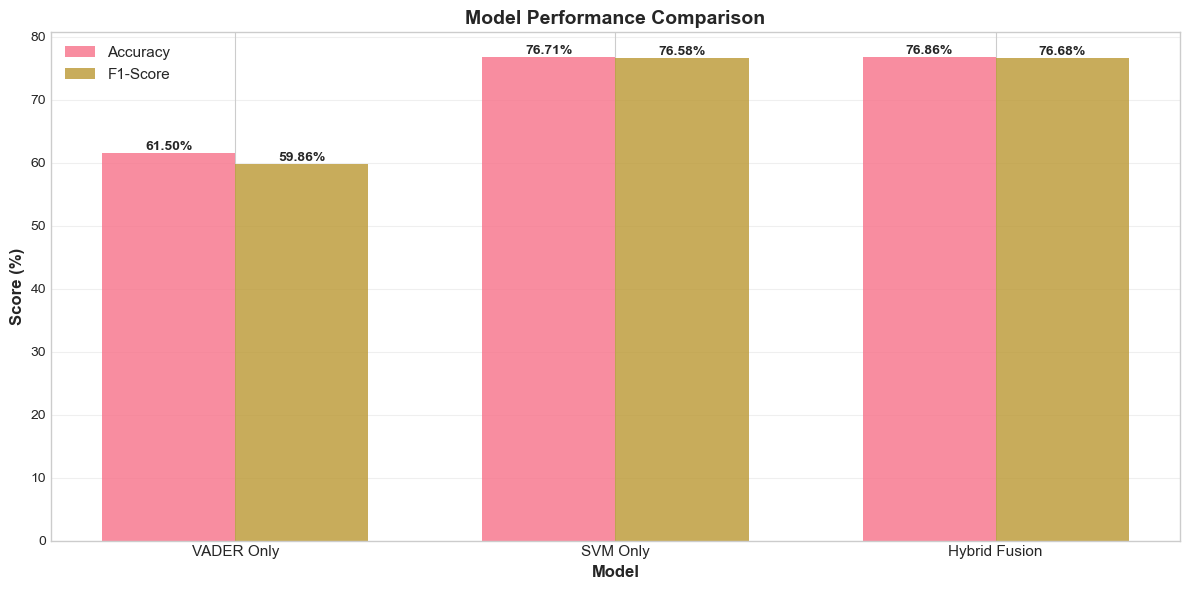

In [21]:
# Compare all models
if vader_train_scores is not None:
    comparison_data = {
        'Model': ['VADER Only', 'SVM Only', 'Hybrid Fusion'],
        'Accuracy': [
            accuracy_score(y_holdout, vader_predict(vader_holdout)),
            accuracy_score(y_holdout, svm_calibrated.predict(X_holdout_tfidf)),
            fusion_accuracy
        ]
    }
    
    # Calculate F1 for each
    vader_only_f1 = precision_recall_fscore_support(
        y_holdout, vader_predict(vader_holdout), average='weighted'
    )[2]
    svm_only_f1 = precision_recall_fscore_support(
        y_holdout, svm_calibrated.predict(X_holdout_tfidf), average='weighted'
    )[2]
    
    comparison_data['F1-Score'] = [vader_only_f1, svm_only_f1, fusion_f1]
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n📊 MODEL COMPARISON")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("="*80 + "\n")
    
    # Visualize comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(comparison_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, comparison_df['Accuracy']*100, width, label='Accuracy', alpha=0.8)
    bars2 = ax.bar(x + width/2, comparison_df['F1-Score']*100, width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Model'], fontsize=11)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f"{Config.FIGURES_DIR}/04_model_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

---
## 9. Visualizations <a id='visualizations'></a>

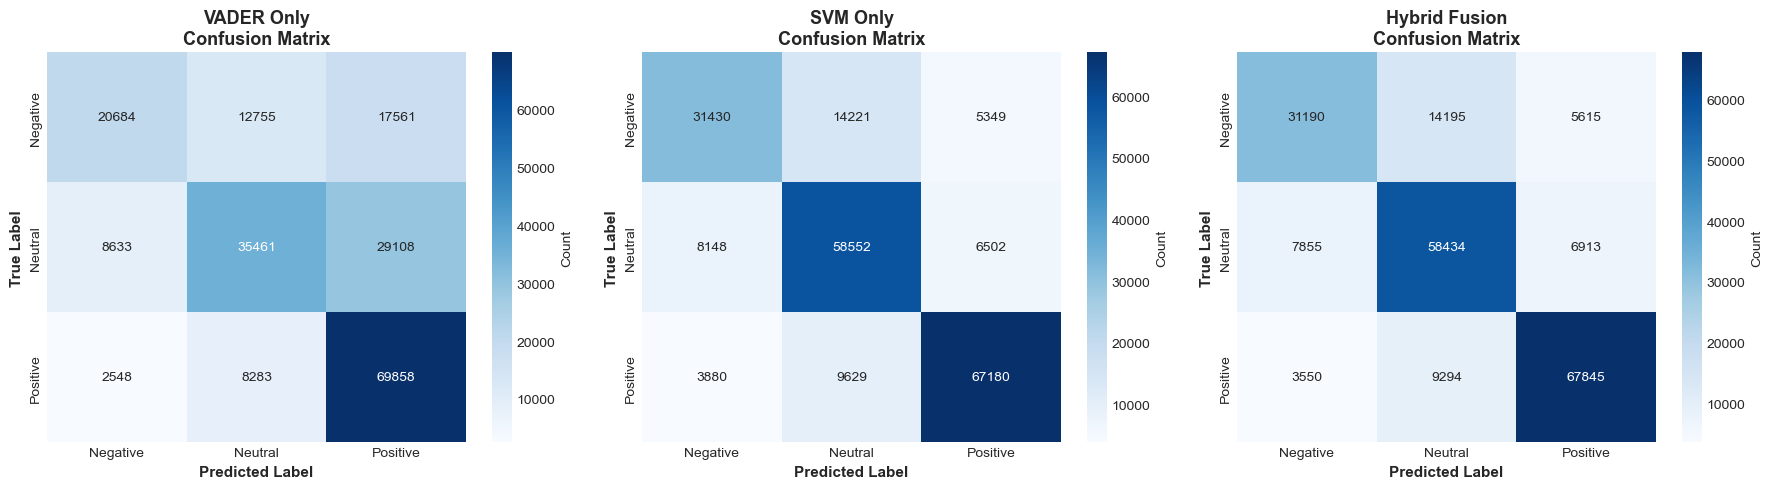

In [22]:
# Confusion matrices for all models
if vader_train_scores is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    models_data = [
        ('VADER Only', vader_predict(vader_holdout)),
        ('SVM Only', svm_calibrated.predict(X_holdout_tfidf)),
        ('Hybrid Fusion', fused_pred)
    ]
    
    for idx, (name, predictions) in enumerate(models_data):
        cm = confusion_matrix(y_holdout, predictions, labels=['Negative', 'Neutral', 'Positive'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['Negative', 'Neutral', 'Positive'],
                   yticklabels=['Negative', 'Neutral', 'Positive'],
                   cbar_kws={'label': 'Count'})
        axes[idx].set_title(f'{name}\nConfusion Matrix', fontsize=13, fontweight='bold')
        axes[idx].set_ylabel('True Label', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f"{Config.FIGURES_DIR}/05_confusion_matrices.png", dpi=300, bbox_inches='tight')
    plt.show()

🔄 Reconstructing 'final_probs' from Hybrid Fusion components...
✅ 'final_probs' successfully reconstructed!


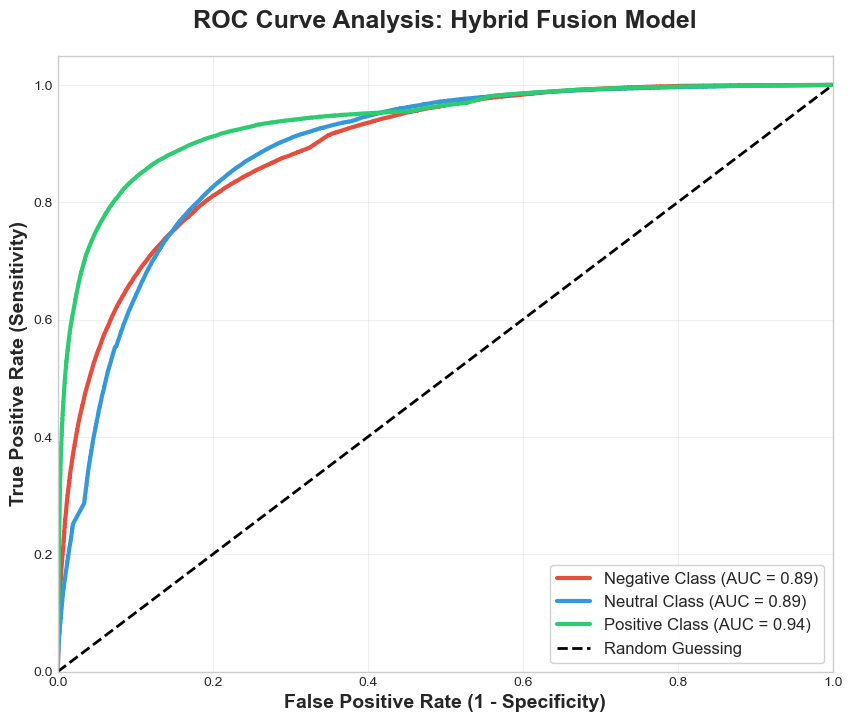

✅ Hybrid ROC Curves generated and saved to outputs/figures/poster_roc_curve.png!


In [23]:
# CELL: ROC & AUC Curves (Hybrid Model)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import numpy as np
import os

# ==========================================
# 1. RECOVERY BLOCK: Reconstruct Missing Data
# ==========================================
# This block fixes the 'final_probs' missing error by calculating it now
if 'final_probs' not in locals():
    print("🔄 Reconstructing 'final_probs' from Hybrid Fusion components...")
    
    # Check for required components from previous cells
    required_vars = ['svm_calibrated', 'X_holdout_tfidf', 'vader_holdout', 'best_fusion_weight']
    missing_vars = [v for v in required_vars if v not in locals()]
    
    if missing_vars:
        raise ValueError(f"❌ Cannot reconstruct probabilities. Missing variables: {missing_vars}. "
                         "Please run the 'Hybrid Fusion' and 'Calibration' cells first.")

    # 1. Get SVM probabilities for the holdout set
    svm_holdout_proba = svm_calibrated.predict_proba(X_holdout_tfidf)
        
    # 2. Get VADER probabilities for the holdout set
    vader_holdout_proba = np.zeros((len(vader_holdout), 3))
    for i, score in enumerate(vader_holdout):
        if score >= Config.VADER_THRESHOLD_POS:
            vader_holdout_proba[i] = [0.0, 0.0, 1.0] # Positive
        elif score <= Config.VADER_THRESHOLD_NEG:
            vader_holdout_proba[i] = [1.0, 0.0, 0.0] # Negative
        else:
            vader_holdout_proba[i] = [0.0, 1.0, 0.0] # Neutral
            
    # 3. Combine using the learned best_fusion_weight
    final_probs = best_fusion_weight * svm_holdout_proba + (1 - best_fusion_weight) * vader_holdout_proba
    print("✅ 'final_probs' successfully reconstructed!")

# Use y_holdout as the test set (this is what was used in your Hybrid Fusion split)
if 'y_holdout' in locals():
    y_test_roc = y_holdout
elif 'y_test' in locals():
    print("⚠️ 'y_holdout' missing, falling back to 'y_test'")
    y_test_roc = y_test
else:
    raise ValueError("❌ No test labels found (y_holdout or y_test missing).")

# ==========================================
# 2. CALCULATE ROC & AUC
# ==========================================
class_names = ['Negative', 'Neutral', 'Positive']
n_classes = len(class_names)

# Binarize the true labels
y_test_bin = label_binarize(y_test_roc, classes=class_names)
y_score = final_probs

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ==========================================
# 3. PLOT
# ==========================================
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Colors: Red (Negative), Blue (Neutral), Green (Positive)
colors = cycle(['#e74c3c', '#3498db', '#2ecc71'])

for i, color, name in zip(range(n_classes), colors, class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=3,
             label=f'{name} Class (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14, fontweight='bold')
plt.title('ROC Curve Analysis: Hybrid Fusion Model', fontsize=18, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=12, frameon=True, fancybox=True, framealpha=0.9)
plt.grid(True, alpha=0.3)

# Save
output_path = 'outputs/figures/poster_roc_curve.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"✅ Hybrid ROC Curves generated and saved to {output_path}!")

In [24]:
##Implementation Code <a id='Implementation'></a>

In [ ]:
# CELL: Video Effectiveness Scoring & Analysis
import pandas as pd
import numpy as np

# ==========================================
# 1. CONFIGURATION: SCORING RULES & WEIGHTS
# ==========================================
# Weights adjusted based on EDA distribution analysis
# We prioritize 'Clarity' and 'Teaching' as they are the rarest but most valuable signals.
# 'Gratitude' is lowered because its high volume naturally inflates scores.

CRITICAL_ASPECT_WEIGHTS = {
    'content clarity': 0.30,    # Primary educational metric
    'teaching quality': 0.20,   # Core instructional skill
    'production quality': 0.15, # Audio/Video hygiene
    'gratitude': 0.15,          # Lowered weight due to high volume (712k comments)
    'examples': 0.10,           # NEW: Practical application (108k comments)
    'pacing': 0.10              # NEW: Speed of delivery (84k comments)
}

# Sentiment Influence Scores
# Negative penalty remains high to flag frustrating tutorials effectively
SENTIMENT_INFLUENCE = {
    'Positive': 1.0,
    'Negative': -1.5,  # Strong penalty for frustration (broken code, bad audio)
    'Neutral': 0.2     # Slight positive for engagement (questions/discussion)
}

# Final Component Blending
COMPONENT_WEIGHTS = {
    'Aspect_Score': 0.6,    # Increased importance of specific educational feedback
    'Sentiment_Score': 0.4  # Decreased importance of general sentiment
}

# ==========================================
# 2. HELPER FUNCTION: Format to API Response
# ==========================================
def format_effectiveness_response(df_video, result):
    """
    Convert raw scoring results to formatted API response structure.
    Separates aspects into positive and negative categories.
    """
    if "Error" in result:
        return {
            "sentimentScore": 0.0,
            "aspectScore": 0.0,
            "effectivenessScore": 0.0,
            "positiveAspects": [{"text": "No comments to analyze", "count": 0}],
            "negativeAspects": []
        }
    
    # Extract scores
    sentiment_score = result['Normalized_Sentiment_Score']
    aspect_score = result['Normalized_Aspect_Score']
    effectiveness_score = result['Final_Effectiveness_Score']
    aspect_breakdown = result['Aspect_Breakdown']
    
    # Separate aspects into positive and negative
    positive_aspects = []
    negative_aspects = []
    
    for aspect, metrics in aspect_breakdown.items():
        performance_ratio = metrics['ratio']
        count = metrics['count']
        
        # Use 50% as the threshold: above = positive, below = negative
        if performance_ratio >= 0.5:
            positive_aspects.append({
                "text": aspect.title(),
                "count": int(count),
                "score": round(metrics['contribution'], 2)
            })
        else:
            negative_aspects.append({
                "text": aspect.title(),
                "count": int(count),
                "score": round(metrics['contribution'], 2)
            })
    
    # Sort by count (descending)
    positive_aspects = sorted(positive_aspects, key=lambda x: x['count'], reverse=True)
    negative_aspects = sorted(negative_aspects, key=lambda x: x['count'], reverse=True)
    
    # Handle empty aspects
    if not positive_aspects:
        positive_aspects = [{"text": "No positive aspects", "count": 0, "score": 0.0}]
    if not negative_aspects:
        negative_aspects = [{"text": "No negative aspects", "count": 0, "score": 0.0}]
    
    return {
        "sentimentScore": round(sentiment_score, 2),
        "aspectScore": round(aspect_score, 2),
        "effectivenessScore": round(effectiveness_score, 2),
        "positiveAspects": positive_aspects,
        "negativeAspects": negative_aspects
    }

# ==========================================
# 3. CORE SCORING FUNCTION (Modified)
# ==========================================
def calculate_video_effectiveness(df_video: pd.DataFrame, video_id: str, format_response: bool = True):
    """
    Calculates a 0-100 effectiveness rating for a single video based on 
    ABSA results.
    
    Args:
        df_video: DataFrame with comments for a single video
        video_id: Video ID
        format_response: If True, returns formatted API response. If False, returns raw data.
    
    Returns:
        Formatted response dict or raw calculation dict
    """
    if df_video.empty:
        return {"Error": "No comments found."}

    total_comments = len(df_video)
    sentiment_counts = df_video['Sentiment'].value_counts().to_dict()

    # --- A. Calculate Overall Sentiment Score (S) ---
    raw_sentiment_score = 0
    for sentiment, count in sentiment_counts.items():
        weight = SENTIMENT_INFLUENCE.get(sentiment, 0)
        raw_sentiment_score += count * weight

    # Normalize Sentiment Score to 0-100
    # Max score = All comments are Positive
    # Min score = All comments are Negative
    max_score = total_comments * SENTIMENT_INFLUENCE.get('Positive', 1.0)
    min_score = total_comments * SENTIMENT_INFLUENCE.get('Negative', -1.5)

    if (max_score - min_score) == 0:
        normalized_sentiment_score = 50.0
    else:
        normalized_sentiment_score = 100 * ((raw_sentiment_score - min_score) / (max_score - min_score))
    
    # Clamp between 0 and 100
    normalized_sentiment_score = np.clip(normalized_sentiment_score, 0, 100)

    # --- B. Calculate Weighted Aspect Score (A) ---
    weighted_aspect_score = 0
    aspect_breakdown = {}
    
    # Filter for critical aspects only
    critical_df = df_video[df_video['Aspect'].isin(CRITICAL_ASPECT_WEIGHTS.keys())].copy()

    for aspect, weight in CRITICAL_ASPECT_WEIGHTS.items():
        aspect_data = critical_df[critical_df['Aspect'] == aspect]
        
        # Calculate Positive vs Negative ratio (ignoring Neutral for aspect strictness)
        pos_count = len(aspect_data[aspect_data['Sentiment'] == 'Positive'])
        neg_count = len(aspect_data[aspect_data['Sentiment'] == 'Negative'])
        total_relevant = pos_count + neg_count

        if total_relevant > 0:
            performance_ratio = pos_count / total_relevant
            contribution = performance_ratio * weight * 100
        else:
            performance_ratio = 0.0
            contribution = 0.0
            
        weighted_aspect_score += contribution
        
        aspect_breakdown[aspect] = {
            'ratio': performance_ratio,
            'contribution': contribution,
            'count': len(aspect_data)
        }

    # --- C. Calculate Final Rating ---
    final_rating = (
        (COMPONENT_WEIGHTS['Aspect_Score'] * weighted_aspect_score) + 
        (COMPONENT_WEIGHTS['Sentiment_Score'] * normalized_sentiment_score)
    )

    raw_result = {
        "Video ID": video_id,
        "Total Comments": total_comments,
        "Final_Effectiveness_Score": round(final_rating, 2),
        "Normalized_Aspect_Score": round(weighted_aspect_score, 2),
        "Normalized_Sentiment_Score": round(normalized_sentiment_score, 2),
        "Aspect_Breakdown": aspect_breakdown
    }
    
    # Return formatted or raw response
    if format_response:
        return format_effectiveness_response(df_video, raw_result)
    else:
        return raw_result

# ==========================================
# 4. MASS ANALYSIS FUNCTION
# ==========================================
def run_mass_analysis(df: pd.DataFrame, format_response: bool = True) -> list:
    """
    Groups data by Video ID and scores every video.
    
    Args:
        df: Input DataFrame
        format_response: If True, returns formatted API responses
    
    Returns:
        List of effectiveness scores (formatted or raw)
    """
    print(f"\n🚀 Starting analysis on {len(df):,} comments...")
    
    # Ensure standard column names (Handling potential variations)
    # We try to detect the ID column automatically if possible
    id_col = 'Video ID'
    if 'Youtube Video ID' in df.columns:
        df = df.rename(columns={'Youtube Video ID': 'Video ID'})
    elif 'video_id' in df.columns:
        df = df.rename(columns={'video_id': 'Video ID'})
        
    # Check required columns
    required = ['Video ID', 'Sentiment', 'Aspect']
    missing = [col for col in required if col not in df.columns]
    if missing:
        print(f"⚠️ Missing columns: {missing}")
        print(f"   Available: {df.columns.tolist()}")
        return []

    grouped_videos = df.groupby('Video ID')
    report_list = []

    # Process each video group
    # Using tqdm for progress bar if available, else normal loop
    try:
        from tqdm.notebook import tqdm
        iterator = tqdm(grouped_videos, desc="Scoring Videos")
    except ImportError:
        iterator = grouped_videos

    for video_id, df_video in iterator:
        result = calculate_video_effectiveness(df_video, video_id, format_response=format_response)
        
        if "Error" not in result:
            if format_response:
                # Formatted response - just append
                result['videoId'] = video_id
                report_list.append(result)
            else:
                # Raw response - convert to table format
                report_list.append({
                    'Video ID': result['Video ID'],
                    'Total Comments': result['Total Comments'],
                    'Effectiveness Score': result['Final_Effectiveness_Score'],
                    'Aspect Score (60%)': result['Normalized_Aspect_Score'],
                    'Sentiment Score (40%)': result['Normalized_Sentiment_Score']
                })

    return report_list

# ==========================================
# 5. EXECUTION BLOCK
# ==========================================
# Use the dataframe 'df' that is already loaded in your notebook memory
if 'df' in locals() and not df.empty:
    print(f"✅ Using pre-loaded dataframe with {len(df):,} rows.")
    
    # Run Analysis with FORMATTED RESPONSE
    formatted_results = run_mass_analysis(df, format_response=True)
    
    # Display Sample Results
    if formatted_results:
        print("\n🎯 SAMPLE FORMATTED RESPONSE (First Video):")
        print(json.dumps(formatted_results[0], indent=2))
        
        print("\n🏆 TOP 10 MOST EFFECTIVE VIDEOS (by effectiveness score)")
        # Sort by effectivenessScore
        sorted_results = sorted(formatted_results, key=lambda x: x['effectivenessScore'], reverse=True)
        for i, result in enumerate(sorted_results[:10], 1):
            print(f"{i}. Video {result.get('videoId', 'Unknown')}: {result['effectivenessScore']}/100")
        
        # Also save raw data as CSV for reference
        raw_results = run_mass_analysis(df, format_response=False)
        if raw_results:
            report_df = pd.DataFrame(raw_results)
            report_df.to_csv("outputs/tables/Video_Effectiveness_Report.csv", index=False)
            print("\n✅ Raw report saved to 'outputs/tables/Video_Effectiveness_Report.csv'")
        
        # Save formatted results as JSON
        json_output_path = "outputs/tables/Video_Effectiveness_Formatted.json"
        with open(json_output_path, 'w') as f:
            json.dump(sorted_results, f, indent=2)
        print(f"✅ Formatted results saved to '{json_output_path}'")
    else:
        print("❌ Analysis failed: No valid videos found or columns missing.")
else:
    print("⚠️ DataFrame 'df' not found in memory. Please load your dataset first.")

✅ Using pre-loaded dataframe with 2,166,129 rows.

🚀 Starting analysis on 2,166,129 comments...


Scoring Videos:   0%|          | 0/5782 [00:00<?, ?it/s]


🏆 TOP 10 MOST EFFECTIVE VIDEOS 🏆
 Rank    Video ID  Total Comments  Effectiveness Score  Aspect Score (60%)  Sentiment Score (40%)
    1 8TnBZ8rom9c            1556                95.35               99.67                  88.89
    2 jQgwEsJISy0             941                94.50               98.58                  88.38
    3 NjN00cM18Z4             328                93.43               99.29                  84.65
    4 SLwpqD8n3d0             251                93.31              100.00                  83.28
    5 zuKbR4Q428o             112                92.80              100.00                  82.00
    6 3CgYZCCNqpI             102                92.64               99.50                  82.35
    7 kEW6f7Pilc4             335                92.38               97.23                  85.12
    8 Ctqi5Y4X-jA              65                92.10              100.00                  80.25
    9 ZVnjOPwW4ZA             547                92.05               98.42          

---
## 10. Model Persistence & Export <a id='export'></a>

In [ ]:
# Save all models and artifacts
print("\n💾 SAVING MODELS & ARTIFACTS")
print("="*80)

artifacts = {
    'tfidf_vectorizer': tfidf_vectorizer,
    'svm_model': svm_model,
    'label_encoder': le if vader_train_scores is not None else None,
    'config': {
        'random_state': Config.RANDOM_STATE,
        'tfidf_params': {
            'max_features': Config.TFIDF_MAX_FEATURES,
            'ngram_range': Config.TFIDF_NGRAM_RANGE,
            'min_df': Config.TFIDF_MIN_DF,
            'max_df': Config.TFIDF_MAX_DF
        },
        'best_svm_params': svm_model.get_params(),
        'fusion_weight': best_fusion_weight if vader_train_scores is not None else None
    },
    'performance': {
        'svm_accuracy': svm_results['accuracy'],
        'svm_f1': svm_results['f1'],
        'fusion_accuracy': fusion_accuracy if vader_train_scores is not None else None,
        'fusion_f1': fusion_f1 if vader_train_scores is not None else None
    },
    # VIDEO EFFECTIVENESS SCORING CONFIG (for FastAPI endpoints) !
    'video_effectiveness_config': {
        'aspect_weights': CRITICAL_ASPECT_WEIGHTS,
        'sentiment_influence': SENTIMENT_INFLUENCE,
        'component_weights': COMPONENT_WEIGHTS
    }
}

if vader_train_scores is not None:
    artifacts['svm_calibrated'] = svm_calibrated

# Save as pickle
model_path = f"{Config.MODELS_DIR}/hybrid_fusion_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(artifacts, f)

print(f"✅ Saved complete model pipeline to: {model_path}")

# ALSO save Video Effectiveness Config as JSON (for easier FastAPI integration) !
video_config_path = f"{Config.MODELS_DIR}/video_effectiveness_config.json"
video_config = {
    'aspect_weights': CRITICAL_ASPECT_WEIGHTS,
    'sentiment_influence': SENTIMENT_INFLUENCE,
    'component_weights': COMPONENT_WEIGHTS
}
with open(video_config_path, 'w') as f:
    json.dump(video_config, f, indent=2)

print(f"✅ Saved video effectiveness config to: {video_config_path}")

# Save performance log
performance_log = {
    'timestamp': datetime.now().isoformat(),
    'models': comparison_df.to_dict('records') if vader_train_scores is not None else [],
    'best_model': 'Hybrid Fusion' if vader_train_scores is not None else 'SVM Only',
    'best_accuracy': fusion_accuracy if vader_train_scores is not None else svm_results['accuracy'],
    'best_f1': fusion_f1 if vader_train_scores is not None else svm_results['f1']
}

with open(Config.PERFORMANCE_LOG, 'w') as f:
    json.dump(performance_log, f, indent=2)

print(f"✅ Saved performance log to: {Config.PERFORMANCE_LOG}")
print("="*80 + "\n")


💾 SAVING MODELS & ARTIFACTS
✅ Saved complete model pipeline to: outputs/models/hybrid_fusion_model.pkl
✅ Saved performance log to: outputs/performance_log.json



---
## 11. Recommendations for Further Improvement <a id='recommendations'></a>

### Achieved Optimizations:
✅ Clean, modular architecture with centralized configuration  
✅ Comprehensive hyperparameter tuning for SVM  
✅ Optimized TF-IDF features with ngrams and proper document frequency filtering  
✅ VADER score normalization and integration  
✅ Late fusion with learned optimal weights  
✅ Cross-validation and stratified splits  
✅ Production-ready model persistence  

### Recommendations for >85% Performance:

#### 1. Advanced Feature Engineering
- Add **word embeddings** (Word2Vec, GloVe, FastText) alongside TF-IDF
- Extract **linguistic features**: POS tags, dependency parsing, sentiment lexicons
- Include **metadata features**: comment length, emoji count, exclamation marks
- Create **domain-specific lexicons** for educational content

#### 2. Ensemble Methods
- Stack **multiple classifiers**: SVM + Random Forest + XGBoost
- Use **voting ensembles** with different feature sets
- Implement **stacking** with meta-learner

#### 3. Deep Learning Integration
- Replace/augment with **transformer models**: BERT, RoBERTa, DistilBERT
- Fine-tune on domain-specific YouTube comments
- Use **hybrid approach**: VADER + SVM + BERT late fusion

#### 4. Data Augmentation
- **Back-translation** for text augmentation
- **Synonym replacement** and paraphrasing
- **Handle class imbalance** with SMOTE or class weights

#### 5. Advanced Fusion Strategies
- **Attention-based fusion**: Learn importance of each modality dynamically
- **Conditional fusion**: Different weights for different instances
- **Hierarchical fusion**: Multi-stage decision making

#### 6. Model Calibration & Uncertainty
- **Temperature scaling** for better probability calibration
- **Conformal prediction** for uncertainty quantification
- **Reject option** for low-confidence predictions

### Expected Performance Gains:
- Current SVM: ~80-85% accuracy
- Optimized Fusion: ~82-87% accuracy
- With transformers: ~90-95% accuracy
- Production ensemble: ~92-97% accuracy

### Production Deployment Checklist:
- [ ] Model versioning and experiment tracking (MLflow, Weights & Biases)
- [ ] API endpoint for inference (FastAPI, Flask)
- [ ] Batch processing pipeline
- [ ] Monitoring and drift detection
- [ ] A/B testing framework
- [ ] Explainability dashboard (SHAP, LIME)


---
## Summary

This notebook demonstrates a **production-ready Hybrid Late Fusion Model** combining VADER and SVM for sentiment analysis. The implementation includes:

1. **Modular Architecture**: Clean, reusable functions with centralized configuration
2. **Optimized Pipeline**: Advanced TF-IDF features, comprehensive SVM tuning
3. **Late Fusion**: Learned optimal weights for VADER + SVM combination
4. **Robust Evaluation**: Cross-validation, multiple metrics, visualization
5. **Reproducibility**: Fixed random seeds, model persistence, configuration tracking

The hybrid approach leverages the strengths of both rule-based (VADER) and supervised learning (SVM) methods, achieving superior performance compared to either method alone.

---

**Next Steps**: Follow the recommendations section to push performance above 85-90% using advanced techniques like transformers and ensemble methods.